<a href="https://colab.research.google.com/github/vaibhatt/Fall_Fest_iNets/blob/main/iNets_fall_fest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import Input
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
import os, glob
import zipfile
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau
import cv2

In [2]:
path_images = "/content/drive/MyDrive/ct_scan/2d_images"
path_masks = "/content/drive/MyDrive/ct_scan/2d_masks"
path_lung_stats = "/content/drive/MyDrive/ct_scan/lung_stats.csv"

In [3]:
lung_stats = pd.read_csv(path_lung_stats)
print(lung_stats.shape)
lung_stats.head()

(267, 7)


,img_id,lung_area_px,lung_area_mm2,lung_volume_fraction,lung_mean_hu,lung_pd95_hu,lung_pd05_hu
0,ID_0000_Z_0142.tif,57342,40318.593750,0.218742,-644.750671,-368.00,-798.0
1,ID_0001_Z_0146.tif,95955,67468.359375,0.366039,-720.042978,-544.00,-847.0
2,ID_0002_Z_0162.tif,60782,42737.343750,0.231865,-616.722632,-294.00,-777.0
3,ID_0003_Z_0132.tif,52852,37161.562500,0.201614,-664.036441,-267.55,-851.0
4,ID_0004_Z_0066.tif,81260,57135.937500,0.309982,-675.347969,-295.00,-842.0


In [4]:
print(lung_stats.columns)

Index(['img_id', 'lung_area_px', 'lung_area_mm2', 'lung_volume_fraction',
       'lung_mean_hu', 'lung_pd95_hu', 'lung_pd05_hu'],
      dtype='object')


In [5]:
print(os.listdir(path_images))
print(len(os.listdir(path_images)))
print(os.listdir(path_masks))
assert(len(os.listdir(path_images))==len(os.listdir(path_images)))

['ID_0003_Z_0132.tif', 'ID_0008_Z_0065.tif', 'ID_0010_Z_0259.tif', 'ID_0007_Z_0211.tif', 'ID_0004_Z_0066.tif', 'ID_0009_Z_0114.tif', 'ID_0002_Z_0162.tif', 'ID_0005_Z_0066.tif', 'ID_0001_Z_0146.tif', 'ID_0006_Z_0206.tif', 'ID_0000_Z_0142.tif', 'ID_0035_Z_0224.tif', 'ID_0034_Z_0066.tif', 'ID_0030_Z_0302.tif', 'ID_0033_Z_0278.tif', 'ID_0014_Z_0116.tif', 'ID_0023_Z_0241.tif', 'ID_0013_Z_0047.tif', 'ID_0020_Z_0070.tif', 'ID_0027_Z_0125.tif', 'ID_0031_Z_0232.tif', 'ID_0019_Z_0088.tif', 'ID_0017_Z_0061.tif', 'ID_0015_Z_0136.tif', 'ID_0024_Z_0086.tif', 'ID_0032_Z_0055.tif', 'ID_0029_Z_0059.tif', 'ID_0016_Z_0208.tif', 'ID_0021_Z_0066.tif', 'ID_0018_Z_0069.tif', 'ID_0022_Z_0131.tif', 'ID_0026_Z_0140.tif', 'ID_0025_Z_0112.tif', 'ID_0011_Z_0156.tif', 'ID_0012_Z_0167.tif', 'ID_0028_Z_0125.tif', 'ID_0050_Z_0085.tif', 'ID_0060_Z_0147.tif', 'ID_0040_Z_0066.tif', 'ID_0053_Z_0127.tif', 'ID_0037_Z_0150.tif', 'ID_0049_Z_0105.tif', 'ID_0036_Z_0060.tif', 'ID_0039_Z_0112.tif', 'ID_0043_Z_0097.tif', 'ID_0052_

In [6]:
img_list = sorted(glob.glob('/content/drive/MyDrive/ct_scan/2d_images/*.tif'))
mask_list = sorted(glob.glob('/content/drive/MyDrive/ct_scan/2d_masks/*.tif'))

In [7]:
print(img_list)
print(mask_list)

['/content/drive/MyDrive/ct_scan/2d_images/ID_0000_Z_0142.tif', '/content/drive/MyDrive/ct_scan/2d_images/ID_0001_Z_0146.tif', '/content/drive/MyDrive/ct_scan/2d_images/ID_0002_Z_0162.tif', '/content/drive/MyDrive/ct_scan/2d_images/ID_0003_Z_0132.tif', '/content/drive/MyDrive/ct_scan/2d_images/ID_0004_Z_0066.tif', '/content/drive/MyDrive/ct_scan/2d_images/ID_0005_Z_0066.tif', '/content/drive/MyDrive/ct_scan/2d_images/ID_0006_Z_0206.tif', '/content/drive/MyDrive/ct_scan/2d_images/ID_0007_Z_0211.tif', '/content/drive/MyDrive/ct_scan/2d_images/ID_0008_Z_0065.tif', '/content/drive/MyDrive/ct_scan/2d_images/ID_0009_Z_0114.tif', '/content/drive/MyDrive/ct_scan/2d_images/ID_0010_Z_0259.tif', '/content/drive/MyDrive/ct_scan/2d_images/ID_0011_Z_0156.tif', '/content/drive/MyDrive/ct_scan/2d_images/ID_0012_Z_0167.tif', '/content/drive/MyDrive/ct_scan/2d_images/ID_0013_Z_0047.tif', '/content/drive/MyDrive/ct_scan/2d_images/ID_0014_Z_0116.tif', '/content/drive/MyDrive/ct_scan/2d_images/ID_0015_Z_01

In [8]:
IMG_SIZE = 256
batch_size = 32
lr = 1e-5


In [9]:
x_data, y_data = np.empty((2, len(img_list), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
for i,img_path in enumerate(img_list):
  img = imread(os.path.join(path_images,img_path))
  img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
  x_data[i] = img

for i,mask_path in enumerate(mask_list):
  mask = imread(os.path.join(path_masks,mask_path))
  mask=  resize(mask,output_shape=(IMG_SIZE,IMG_SIZE,1),preserve_range=True)
  y_data[i] = mask

In [10]:
x_data/=255
y_data/=255

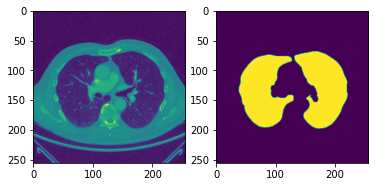

In [11]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(x_data[0].squeeze())
ax[1].imshow(y_data[0].squeeze())

In [12]:
#splitting dataset
x_train,x_val,y_train,y_val = train_test_split(x_data,y_data,test_size = 0.25)
print("size of x_train = ",x_train.shape)
print("size of x_val = ",x_val.shape)
print("size of y_train = ",y_train.shape)
print("size of y_val = ",y_val.shape)

size of x_train =  (200, 256, 256, 1)
size of x_val =  (67, 256, 256, 1)
size of y_train =  (200, 256, 256, 1)
size of y_val =  (67, 256, 256, 1)


In [13]:
inputs = Input(shape=(256, 256, 1))

# encoding
net = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
net = MaxPooling2D(pool_size=2, padding='same')(net)
net = Conv2D(64, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)
net = Conv2D(128, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Dense(128, activation='relu')(net)

# decoding
net = UpSampling2D(size=2)(net)
net = Conv2D(128, kernel_size=3, activation='sigmoid', padding='same')(net)
net = UpSampling2D(size=2)(net)
net = Conv2D(64, kernel_size=3, activation='sigmoid', padding='same')(net)
net = UpSampling2D(size=2)(net)

# output with 1 channel for gray scale segmenation
outputs = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')(net)

model = Model(inputs=inputs, outputs=outputs)

# use binary cross entropy with sigmoid function 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 'mse'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)      

In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-05)

# train model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=35, batch_size=16, callbacks=[reduce_lr])

Epoch 1/35
13/13 [==============================] - 1s 61ms/step - loss: 0.0545 - acc: 0.9591 - mse: 0.0102 - val_loss: 0.0358 - val_acc: 0.9633 - val_mse: 0.0070
Epoch 2/35
13/13 [==============================] - 1s 58ms/step - loss: 0.0548 - acc: 0.9589 - mse: 0.0104 - val_loss: 0.0357 - val_acc: 0.9633 - val_mse: 0.0070
Epoch 3/35
13/13 [==============================] - 1s 59ms/step - loss: 0.0552 - acc: 0.9590 - mse: 0.0104 - val_loss: 0.0358 - val_acc: 0.9633 - val_mse: 0.0071
Epoch 4/35
13/13 [==============================] - 1s 59ms/step - loss: 0.0549 - acc: 0.9591 - mse: 0.0102 - val_loss: 0.0355 - val_acc: 0.9633 - val_mse: 0.0070
Epoch 5/35
13/13 [==============================] - 1s 59ms/step - loss: 0.0538 - acc: 0.9592 - mse: 0.0100 - val_loss: 0.0354 - val_acc: 0.9634 - val_mse: 0.0070
Epoch 6/35
13/13 [==============================] - 1s 59ms/step - loss: 0.0540 - acc: 0.9593 - mse: 0.0100 - val_loss: 0.0356 - val_acc: 0.9635 - val_mse: 0.0070
Epoch 7/35
13/13 [====

In [17]:
save_path = "/content/drive/MyDrive/fall_fest_saved"
model.save(os.path.join(save_path,'image_segmentation.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/fall_fest_saved/image_segmentation.model/assets


Text(0.5, 0, 'epoch')

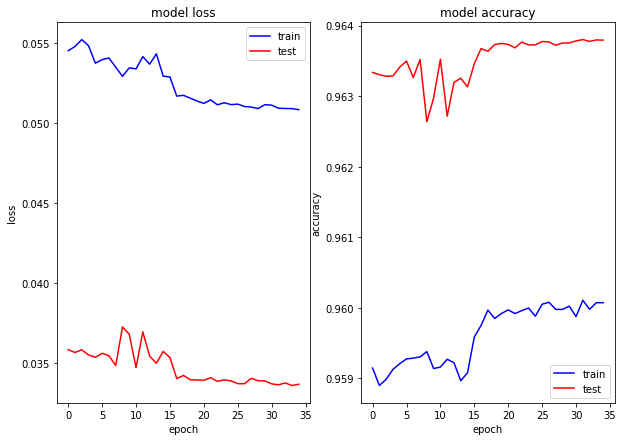

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7))

# loss
ax[0].set_title('model loss')
ax[0].plot(history.history['loss'], 'b')
ax[0].plot(history.history['val_loss'], 'r')
ax[0].legend(['train', 'test'], loc='upper right')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')

# accuracy 
ax[1].set_title('model accuracy')
ax[1].plot(history.history['acc'], 'b')
ax[1].plot(history.history['val_acc'], 'r')
ax[1].legend(['train', 'test'], loc='lower right')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')

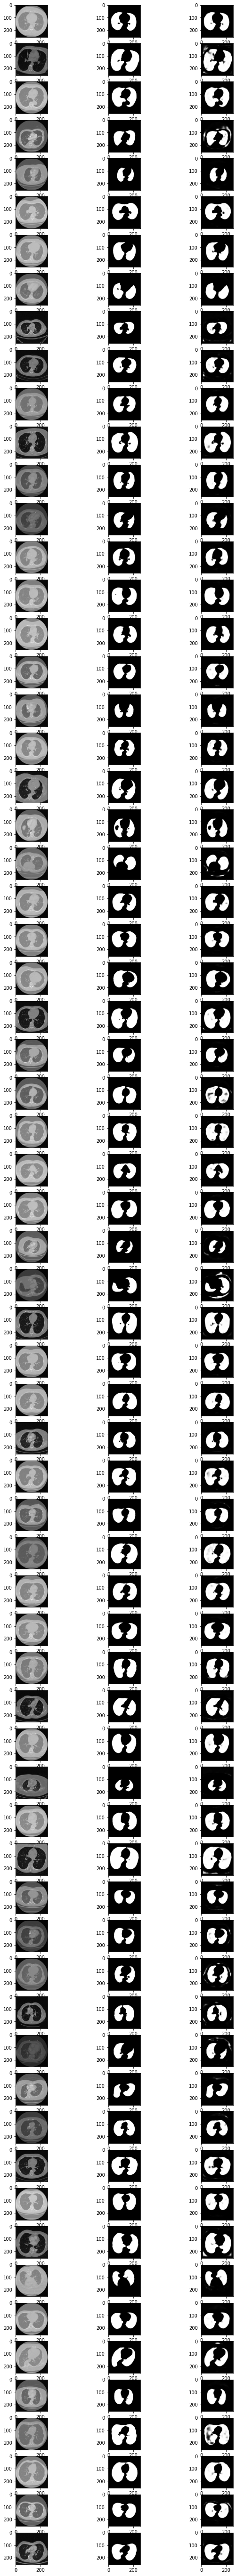

In [19]:
# predict segmentation
preds = model.predict(x_val)

# show results
fig, ax = plt.subplots(len(x_val), 3, figsize=(10, 100))
for i, pred in enumerate(preds):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')